# MIS780 Advanced AI For Business - Assignment 2 - T2 2021

## Part B:  Deep Learning for Image Data

**Student Name:** Hoang Manh Nguyen

**Student ID:** 219380205

*Markdown formats: All tables and images will be aligned to the left. (Do not remove this code)*

In [1]:
%%html
<style>table {float:left}</style>
<style>img {float:left}</style>

<hr style="height:1px;border:none;color:#333;background-color:#333;" />

**Task Description**

1. Organise the Denoising Autoencoder (DAE) project structure, get data and run the notebook.
2. Experiment with batch and epochs for model training.
3. Experiment with DAE optimisers and their parameters (e.g. SGD, RMSprop, Adam, Adamax, Nadam).
4. Change the DAE details / architecture
5. Report your experimental results.
6. Include performance results and charts for your experiment runs.
7. Save the IPYNB notebook, convert it to PDF (via HTML) and submit both for assessment.

**NOTE: In your reponses below, you can create multiple Markdown and Code cells to present your work where needed. Remove the *instructional text in italic* and provide your explanations to the code procedures.**
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

## Table of Content
   
1. [Notebook Preparation](#cell_Preparation)

2. [Data Preprocessing](#cell_Preprocessing)

3. [Model Construction](#cell_model)

4. [Model Execution](#cell_execution)
 
5. [Experiments Report](#cell_report)



<a id = "cell_Preparation"></a>
## 1. Notebook Preparation

We load all required Python libraries (e.g. pandas, tensorflow, keras)

Also. develop code to define some common features and functions (output display, plots) which will be used in later part

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import UpSampling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD, RMSprop, Adadelta, Adam, Nadam

In [3]:
# PLot image
def plot_images(ims, xsize=6, ysize=6, cols=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        if (ims.shape[-1] != 3):
            ims = ims = ims[:,:,:,0]
    f = plt.figure(figsize=(xsize, ysize))
    rows=len(ims)//cols if len(ims) % cols == 0 else len(ims)//cols + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        plt.gray()

In [4]:
# PLot history
%matplotlib inline

def plot_hist(h, xsize=6, ysize=10):
    
    # Find what measurements were recorded
    meas = h.keys()
    
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    
    # Plot each measurement
    meas_list = []
    for m in meas:
        plt.plot(h[m])
        meas_list.append(m)

    # Add info to the plot
    ylab = ', '
    plt.ylabel(ylab.join(meas_list))
    plt.xlabel('epoch')
    plt.legend(meas_list) #, loc='upper left')
    plt.show()
    return

In [5]:
# Calculates image to image errors
def rmse_images(images1, images2):
    return math.sqrt(np.square(np.subtract(images1, images2)).mean())

def mae_images(images1, images2):
    return np.abs(np.subtract(images1, images2)).mean()

<a id = "cell_Preprocessing"></a>
## 2. Data Preprocessing

- Load cifar10 images from keras librabies
- Preprocess data: 
  - convert to 8 bit
  - split and shuffle data to create train and valid data
  - reshape
  - inject noise = 0.3 to both train and validatin data

In [6]:
from tensorflow.keras.datasets import cifar10

# Data parameters
img_rows, img_cols, img_ch = 32, 32, 3

# the data, shuffled and split between train and test sets
(x_train, _), (x_test, _) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

170508288/170498071 [==============================] - 11s 0us/step


In [7]:
# Reshape images for processing

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, img_ch)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, img_ch)
input_shape = (img_rows, img_cols, img_ch)

print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [8]:
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [9]:
print(x_train_noisy.shape)
print(x_test_noisy.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


*Plot original "clean" images and noisy images.*

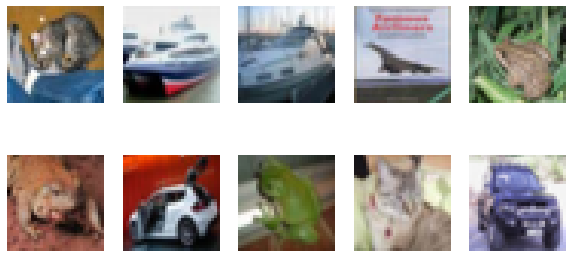

In [10]:
# plot original images 
plot_images(x_test[0:10], cols=5, xsize=10, ysize=5)

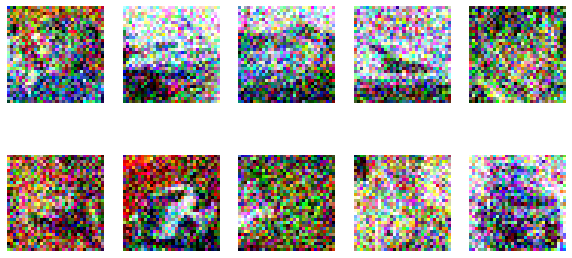

In [11]:
# plot noisy images 
plot_images(x_test_noisy[0:10], cols=5, xsize=10, ysize=5)

<a id = "cell_model"></a>
## 3. Model Construction

In [31]:
#Model 1

input_img = Input(shape=input_shape)

x = Conv2D(16, (3, 3), padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (8,8,16)

x = Conv2D(16, (3, 3), padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

x = Conv2D(16, (3, 3), padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 16, 16, 16)        2320      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 8, 8, 16)          2320      
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, 16, 16, 16)        0   

In [47]:
#Model 2
input_img2 = Input(shape=input_shape)

x2 = Conv2D(32, (3, 3), padding='same', activation = "relu", kernel_regularizer=regularizers.l1_l2(1e-4))(input_img2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D((2, 2), padding='same')(x2)

x2 = Conv2D(16, (3, 3), padding='same', activation = "relu", kernel_regularizer=regularizers.l1_l2(1e-4))(x2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D((2, 2), padding='same')(x2)

x2 = Conv2D(8, (3, 3), padding='same', activation = "relu", kernel_regularizer=regularizers.l1_l2(1e-4))(x2)
x2 = BatchNormalization()(x2)
encoded2 = MaxPooling2D((2, 2), padding='same')(x2)

x2 = Conv2D(8, (3, 3), padding='same', activation = "relu", kernel_regularizer=regularizers.l1_l2(1e-4))(encoded2)
x2 = BatchNormalization()(x2)
x2 = UpSampling2D((2, 2))(x2)

x2 = Conv2D(16, (3, 3), padding='same', activation = "relu", kernel_regularizer=regularizers.l1_l2(1e-4))(x2)
x2 = BatchNormalization()(x2)
x2 = UpSampling2D((2, 2))(x2)

x2 = Conv2D(32, (3, 3), padding='same', activation = "relu", kernel_regularizer=regularizers.l1(1e-4))(x2)
x2 = BatchNormalization()(x2)
x2 = UpSampling2D((2, 2))(x2)
decoded2 = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x2)

autoencoder2 = Model(input_img2, decoded2)
autoencoder2.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_12 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 16, 16, 16)        4624      
_________________________________________________________________
batch_normalization_13 (Batc (None, 16, 16, 16)        64        
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 8, 16)          0   

<a id = "cell_execution"></a>
## 4. Model Execution

In this section:
- fit the models. 
-Denoise the images on the test sets and visualize the denoised images for both models.
- Calculate the MAE (between the original and denoised images) on the test sets to compare the performance of the two models

**Model 1**

In [33]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20, verbose=0)]

opt = Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

#Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)

autoencoder.compile(optimizer=opt, loss='binary_crossentropy')
hist = autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=callbacks)

Epoch 1/100
196/196 [==============================] - 7s 32ms/step - loss: 0.5968 - val_loss: 0.5902
Epoch 2/100
196/196 [==============================] - 6s 30ms/step - loss: 0.5865 - val_loss: 0.5849
Epoch 3/100
196/196 [==============================] - 6s 31ms/step - loss: 0.5829 - val_loss: 0.5825
Epoch 4/100
196/196 [==============================] - 6s 30ms/step - loss: 0.5809 - val_loss: 0.5808
Epoch 5/100
196/196 [==============================] - 6s 30ms/step - loss: 0.5795 - val_loss: 0.5798
Epoch 6/100
196/196 [==============================] - 6s 30ms/step - loss: 0.5785 - val_loss: 0.5788
Epoch 7/100
196/196 [==============================] - 6s 30ms/step - loss: 0.5777 - val_loss: 0.5780
Epoch 8/100
196/196 [==============================] - 6s 30ms/step - loss: 0.5770 - val_loss: 0.5774
Epoch 9/100
196/196 [==============================] - 6s 31ms/step - loss: 0.5764 - val_loss: 0.5769
Epoch 10/100
196/196 [==============================] - 6s 30ms/step - loss: 0.575

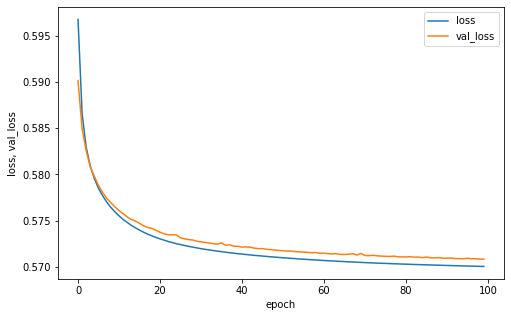

In [34]:
plot_hist(hist.history, xsize=8, ysize=5)

In [35]:
# encode and decode some digits from the test set
decoded_noisy_imgs = autoencoder.predict(x_test_noisy)

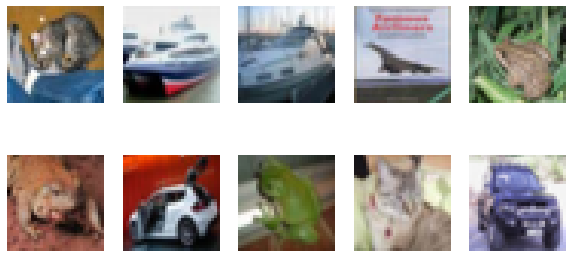

In [36]:
#Original images
plot_images(x_test[0:10], cols=5, xsize=10, ysize=5)

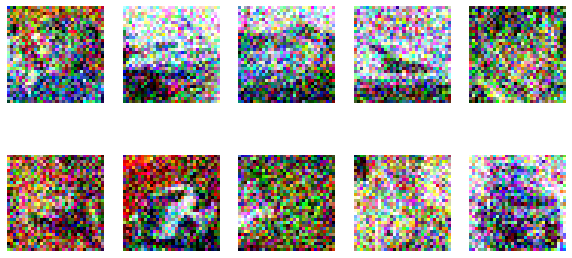

In [37]:
#Images with injected noise
plot_images(x_test_noisy[0:10], cols=5, xsize=10, ysize=5)

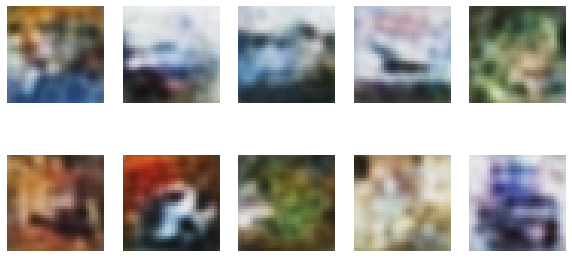

In [38]:
#Denoised images
plot_images(decoded_noisy_imgs[0:10], cols=5, xsize=10, ysize=5)

In [39]:
print('Original vs noisy MAE = \t', round(mae_images(x_test, x_test_noisy), 5))
print('Original vs denoised MAE = \t', round(mae_images(x_test, decoded_noisy_imgs), 5))

Original vs noisy MAE = 	 0.20253
Original vs denoised MAE = 	 0.07049


**Model 2**

In [48]:
callbacks2 = [EarlyStopping(monitor='val_loss', patience=20, verbose=0)]

opt2 = Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

autoencoder2.compile(optimizer=opt2, loss='binary_crossentropy')
hist2 = autoencoder2.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=callbacks2)

Epoch 1/100
391/391 [==============================] - 14s 28ms/step - loss: 1.2212 - val_loss: 1.0497
Epoch 2/100
391/391 [==============================] - 10s 26ms/step - loss: 0.9214 - val_loss: 0.8407
Epoch 3/100
391/391 [==============================] - 11s 29ms/step - loss: 0.7666 - val_loss: 0.7388
Epoch 4/100
391/391 [==============================] - 11s 29ms/step - loss: 0.6815 - val_loss: 0.6878
Epoch 5/100
391/391 [==============================] - 11s 27ms/step - loss: 0.6356 - val_loss: 0.6607
Epoch 6/100
391/391 [==============================] - 10s 26ms/step - loss: 0.6119 - val_loss: 0.6364
Epoch 7/100
391/391 [==============================] - 10s 26ms/step - loss: 0.6004 - val_loss: 0.6138
Epoch 8/100
391/391 [==============================] - 10s 26ms/step - loss: 0.5940 - val_loss: 0.6059
Epoch 9/100
391/391 [==============================] - 10s 26ms/step - loss: 0.5901 - val_loss: 0.5943
Epoch 10/100
391/391 [==============================] - 10s 27ms/step - l

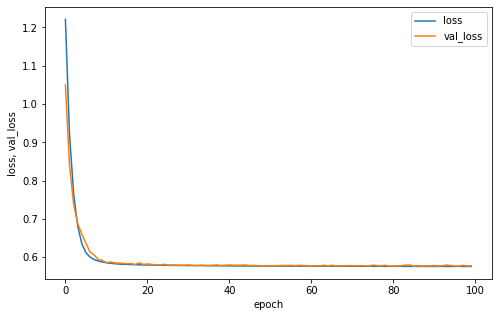

In [49]:
plot_hist(hist2.history, xsize=8, ysize=5)

In [50]:
# encode and decode some digits from the test set
decoded_noisy_imgs2 = autoencoder2.predict(x_test_noisy)

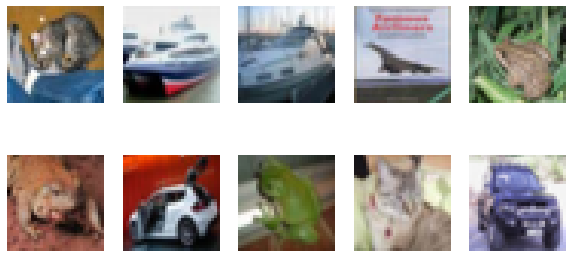

In [51]:
#Original images
plot_images(x_test[0:10], cols=5, xsize=10, ysize=5)

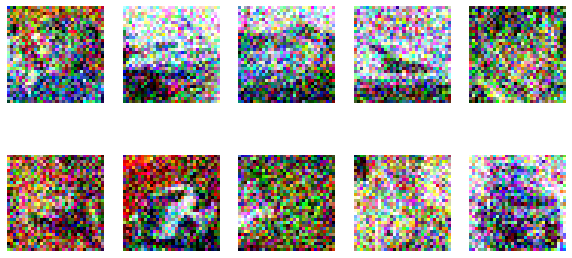

In [52]:
#Images with injected noise
plot_images(x_test_noisy[0:10], cols=5, xsize=10, ysize=5)

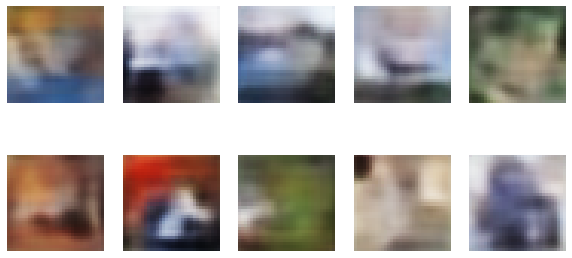

In [53]:
#Denoised images
plot_images(decoded_noisy_imgs2[0:10], cols=5, xsize=10, ysize=5)

In [54]:
print('Original vs noisy MAE = \t', round(mae_images(x_test, x_test_noisy), 5))
print('Original vs denoised MAE = \t', round(mae_images(x_test, decoded_noisy_imgs2), 5))

Original vs noisy MAE = 	 0.20253
Original vs denoised MAE = 	 0.07741


<a id = "cell_report"></a>
## 5. Experiments Report

**Summary of experimental results**


| Model# |  Original vs noisy MAE | Original vs denoised MAE |
| :-: | -: | -: |
| 1 | 0.20253 | 0.07049 |  |
| 2 | 0.20253 | 0.07741  |   |

Model 2 results < Model 1 result


**Model 1**: 2 encode layer, 2 decode layer, no activation function, no regularizer

-> graph shows a very slight overtraining

**Model 2** 3 encode layer, 3 decode layer, activation "relu" and regualarizer l1,l2, also use BatchNormalization

As Model 2 are devopled with more advanced features to control the training, prevent overtraining and improve performance, Model 2 is the best model even Model 2 result is lower